/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/201616-exported.nxs
EMAnalyser object created with 2623437 weighted events in range -661.5 - 661.5


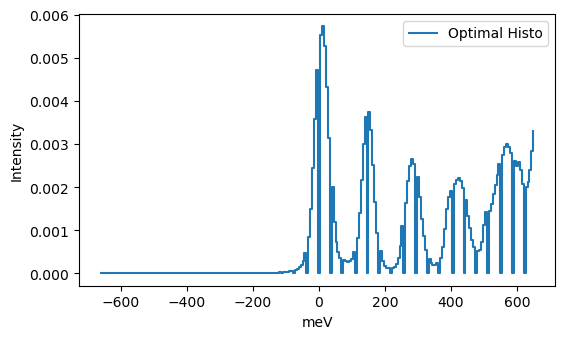

In [218]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

import lmfit 

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform

import copy


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, this lets us change the source and force reload
# However, whilst the error reporting line number is right, the printout of
# the offending source is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/"
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

ema1.plot_histogram(loglog=False, log=False, xlabel='meV')



Least squares model function defined.


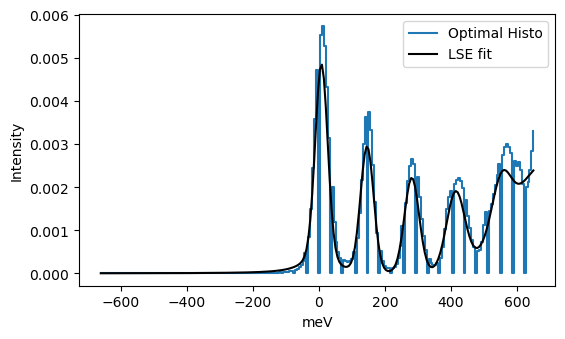

['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[1.03166976e+00 7.83319976e+00 1.45695047e+02 2.81254328e+02
 4.14035526e+02 5.52327378e+02 6.99999691e+02 2.30190791e-02
 1.86422670e+01 1.99165093e+01 2.21066916e+01 2.75136714e+01
 2.79613790e+01 1.16801601e+02 4.02817313e+01 1.90420268e-01
 1.40207127e-01 1.18191129e-01 1.18351136e-01 7.89817013e-02
 2.74781599e-01]
[4.61820689e-02 6.77407450e+00 2.42608681e+00 3.35152531e+00
 5.96478512e+00 1.22412580e+01 3.09337227e+02 3.62514381e+01
 3.89449285e+00 2.56288306e+00 3.38997008e+00 7.33200369e+00
 1.78787566e+01 5.13883390e+13 1.76492899e+02 2.18159185e-01
 1.82600064e-02 1.60267612e-02 4.38465615e-02 9.72543769e-02
 1.23466682e-01]


In [219]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)
    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)


ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=10.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

lse_starting_parameters = copy.deepcopy(ema1.least_squares_parameters)

#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
ema1.plot_LSE_fit(loglog=False, log=False, xlabel='meV', save="/Users/phillipbentley/Code/python/mle/arcs_lse_fit.png")

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

detailed_fit_params = pvals

psigs = ema1.get_lse_param_sigmas()
print(psigs)

detailed_fit_sigmas = psigs

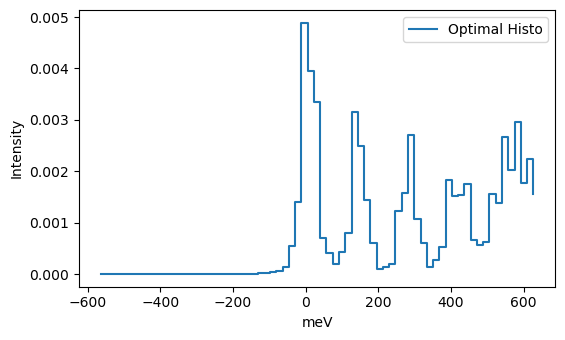

In [220]:
cpo = ema1.subsample(100000)
cpo.plot_histogram(loglog=False,log=False, xlabel='meV')
#cpo.plot_kde(loglog=False,log=False)

Yeah OK I need to fix that KDE...!

In [221]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    if -100.0 < elmu < 100.0 and \
        100.0 < mu1  < 200.0 and \
        200.0 < mu2  < 350.0 and \
        350.0 < mu3  < 450.0 and \
        500.0 < mu4  < 620.0 and \
        600.0 < mubg1< 700.0 and \
        0.0   < mubg2< 200.0 and \
        10.0 < elsigma < 100.0 and \
        10.0 < s1 < 100.0 and \
        10.0 < s2 < 100.0 and \
        10.0 < s3 < 100.0 and \
        10.0 < s4 < 100.0 and \
        100.0 < sbg1 < 250.0 and \
        10.0  < sbg2 < 250.0 and \
        0.1 < m1 < 1.0 and\
        0.1 < m2 < 1.0 and\
        0.1 < m3 < 1.0 and\
        0.1 < m4 < 1.0 and\
        0.1 < mbg1 < 1.0 and\
        0.1 < mbg2 < 1.0 and\
        m1 + m2 + m3 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin


    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(xx, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(xx, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(xx, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(xx, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(xx, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(xx, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(xx, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = (el + l1 + l2 + l3 + l4 + bg1 + bg2)**use_weights
    
    return sol



def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):

    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf

    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))
    


    el = mvals[0] * norm.pdf(data, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)
    l1 = mvals[1] * norm.pdf(data, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(data, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(data, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(data, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(data, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(data, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)


    lel = np.log(el)
    ll1 = np.log(l1)
    ll2 = np.log(l2)
    ll3 = np.log(l3)
    ll4 = np.log(l4)
    lbg1 = np.log(bg1)
    lbg2 = np.log(bg2)

    lt1 = np.logaddexp(lel, ll1)
    lt2 = np.logaddexp(lt1, ll2)
    lt3 = np.logaddexp(lt2, ll3)
    lt4 = np.logaddexp(lt3, ll4)
    lt5 = np.logaddexp(lt4, lbg1)
    lt6 = np.logaddexp(lt5, lbg2)

    lll = np.sum(lt6 * use_weights)
    
    result = lp + lll

    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
    
    return result


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
cpo.theta_seed = np.array([7.83319976e+00, 1.45695047e+02, 2.81254328e+02,\
 4.14035526e+02, 5.52327378e+02, 6.99999691e+02, 2.30190791e-02,\
 1.86422670e+01, 1.99165093e+01, 2.21066916e+01, 2.75136714e+01,\
 2.79613790e+01, 1.16801601e+02, 4.02817313e+01, 1.90420268e-01,\
 1.40207127e-01, 1.18191129e-01, 1.18351136e-01, 7.89817013e-02,\
 2.74781599e-01])

# Seed MCMC search with LSE fit
cpo.lse_fit()
cpo.theta_seed = detailed_fit_params # <- this takes parameters from the detailed fit done earlier
cpo.theta_seed = cpo.theta_seed[1:]

cpo.nwalkers=128 # need to increase this to improve sampling stats quality 
# (see plots of MCMC_parameter_distribution later) 
cpo.MCMC_fit(niter=200)

MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  3.93it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:51<00:00,  3.88it/s]

MCMC sampling complete.


In [222]:
# The standard deviation is the square root of the variance.
# Therefore, the variance should be the standard deviation squared.

chz = cpo.sampler.get_chain()
nw = float(cpo.nwalkers)
nd = float(cpo.ndim)
ns = float(chz.shape[0])

print(chz.shape)

mns = np.mean(chz, axis=0)
print("mean shape", mns.shape)
gmn = np.mean(mns, axis=0)
print("gmn  shape", gmn.shape)


wch_variance = 1.0 / (ns - 1.0) * np.sum( (chz - mns)**2.0, axis=0)
print("wchv shape", wch_variance.shape)
wch_var_alt = np.std(chz, axis=0)**2.0
print("w alt shape", wch_var_alt.shape)


bch_variance = ns/(nw - 1.0) * np.sum( (mns - gmn)**2.0, axis=0)
print("bchv shape", bch_variance.shape)

print(bch_variance)

bch_alt_variance = np.std(mns, axis=0)**2.0
print("b alt shape", bch_alt_variance.shape)
print(bch_alt_variance)


ww = (1.0 / nw) * np.sum(wch_variance, axis=0)

wwalt = np.mean(wch_var_alt, axis=0)

print("ww shape", ww.shape)
print("wwalt sh", wwalt.shape)

print("ww", ww)
print("wwalt", wwalt)

t1 = (ns-1.0)*ww / ns
t2 = bch_variance / ns

t1alt = (ns-1.0) * wwalt / ns
t2alt = (bch_alt_variance)

print("t1 shape", t1.shape)
print("t2 shape", t2.shape)

grstat = (t1 + t2) / ww
print(grstat)

gralt = (t1alt + t2alt) / wwalt
print(gralt)


(200, 128, 20)
mean shape (128, 20)
gmn  shape (20,)
wchv shape (128, 20)
w alt shape (128, 20)
bchv shape (20,)
[2.09824724e-08 1.92950277e-08 1.94743599e-08 1.63627623e-08
 2.13182140e-08 1.74275447e-08 2.12721424e-08 1.77639858e-08
 1.47260613e-08 2.08245300e-08 2.04852119e-08 2.21544565e-08
 1.98083648e-08 2.03988034e-08 2.34996279e-08 2.23995841e-08
 1.85581215e-08 2.11803215e-08 2.05059580e-08 1.94066648e-08]
b alt shape (20,)
[1.04092734e-10 9.57214264e-11 9.66110825e-11 8.11746413e-11
 1.05758327e-10 8.64569602e-11 1.05529769e-10 8.81260232e-11
 7.30550699e-11 1.03309192e-10 1.01625856e-10 1.09906874e-10
 9.82680598e-11 1.01197189e-10 1.16580185e-10 1.11122937e-10
 9.20656808e-11 1.05074251e-10 1.01728776e-10 9.62752510e-11]
ww shape (20,)
wwalt sh (20,)
ww [4.76667468e-28 1.96880654e-25 7.07961039e-25 9.58163934e-25
 2.60604759e-24 2.73949590e-24 3.10859776e-33 3.40419247e-27
 4.13022200e-27 3.76651351e-27 4.37461031e-27 5.59476803e-27
 8.94211495e-26 1.49395985e-26 2.08900492

In [223]:
  def gsdev(mcmcObject, burn=50) -> np.ndarray :

        # Something is a bit wrong with this.
        # The statistic is starting out at a value of 2
        # in the ARCS test notebook and gently increasing
        # It should not be behaving in this way, there is obviously
        # a mistake in the maths below...

        chains = mcmcObject.sampler.get_chain(discard=burn)
            
        nwk = mcmcObject.nwalkers # "J"
        ndm = mcmcObject.ndim
        nsamps = chains.shape[0] #"L"

        chain_mean = np.mean(chains, axis=0)        
        grand_mean = np.mean(chain_mean, axis=0)

        within_chain_variance = 1.0 / (nsamps - 1.0) * np.sum( (chains - grand_mean)**2.0, axis=0)
        between_chain_variance = nsamps/(nwk - 1.0) * np.sum( (chain_mean - grand_mean)**2.0, axis=0)
        
        ww = (1.0 / nwk) * np.sum(within_chain_variance, axis=0)
        
        t1 = (nsamps-1.0)*ww / nsamps
        t2 = between_chain_variance / nsamps
        
        grstat = (t1 + t2) / ww
        
        return grstat

gs0 = gsdev(cpo, burn=0)
gs10 = gsdev(cpo, burn=10)
gs50 = gsdev(cpo, burn=50)
gs100= gsdev(cpo, burn=100)
gs150= gsdev(cpo, burn=150)

print(gs0)
print(gs10)
print(gs50)
print(gs100)
print(gs150)

[1.99783465 1.99783464 1.99783464 1.99783467 1.99783467 1.99783456
 1.99783465 1.99783465 1.99783465 1.99783465 1.99783465 1.99783465
 1.99783465 1.99783465 1.99783465 1.99783465 1.99783465 1.99783465
 1.99783465 1.99783465]
[1.99730626 1.99730625 1.99730626 1.99730628 1.99730628 1.99730617
 1.99730626 1.99730626 1.99730626 1.99730626 1.99730626 1.99730626
 1.99730626 1.99730626 1.99730626 1.99730626 1.99730626 1.99730626
 1.99730626 1.99730626]
[1.99448819 1.99448819 1.99448819 1.9944882  1.99448819 1.99448814
 1.99448819 1.99448819 1.99448819 1.99448819 1.99448819 1.99448819
 1.99448819 1.99448819 1.99448819 1.99448819 1.99448819 1.99448819
 1.99448819 1.99448819]
[1.98779528 1.98779528 1.98779528 1.98779528 1.98779525 1.98779531
 1.98779528 1.98779528 1.98779528 1.98779528 1.98779528 1.98779528
 1.98779528 1.98779527 1.98779528 1.98779528 1.98779528 1.98779528
 1.98779528 1.98779528]
[1.96771654 1.96771654 1.96771654 1.96771653 1.96771654 1.96771655
 1.96771654 1.96771654 1.96771654

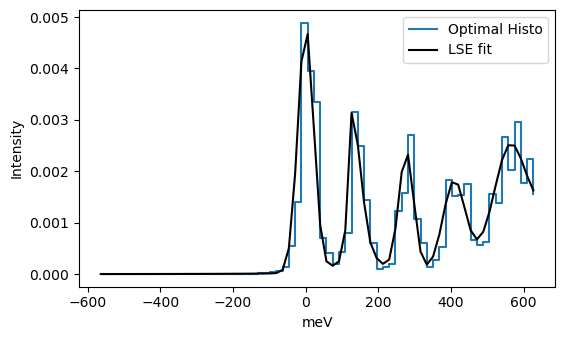

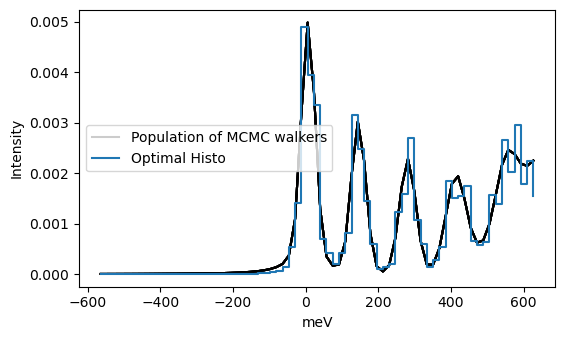

In [224]:
cpo.plot_LSE_fit(loglog=False, log=False, xlabel='meV')
cpo.plot_MCMC_fit(method="histo", loglog=False, log=False, xlabel='meV', save="arcs_mcmc_fit.png")

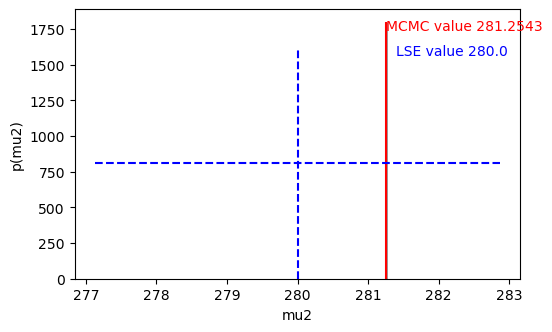

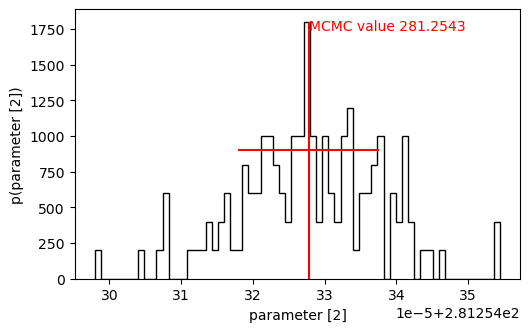

In [225]:
lookat=2
cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False)

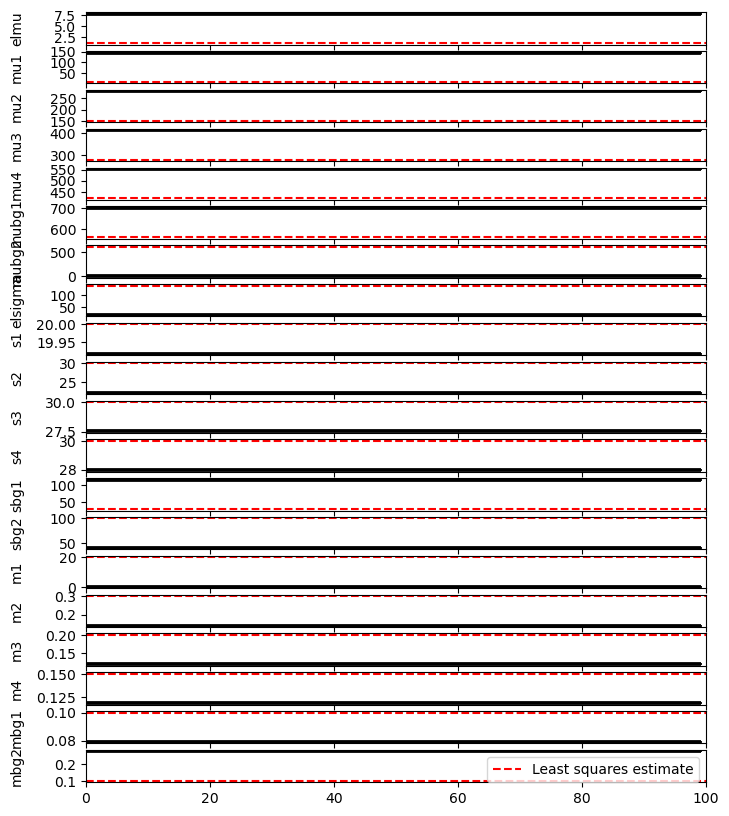

In [226]:
cpo.plot_MCMC_convergences()

In [227]:
mcparams, mcerr = cpo.get_MCMC_parameters()

import pandas

pn = cpo.get_lse_param_names()
pn = pn[1:]

df = pandas.DataFrame({"PARAMETER": pn, "LSE": detailed_fit_params[1:], "LSE_ERR": detailed_fit_sigmas[1:], "BAYES": mcparams, "BAYES_ERR": mcerr})
print(df)



   PARAMETER         LSE       LSE_ERR       BAYES     BAYES_ERR
0       elmu    7.833200  6.774075e+00    7.833200  6.376615e-08
1        mu1  145.695047  2.426087e+00  145.695047  6.114833e-08
2        mu2  281.254328  3.351525e+00  281.254328  6.143184e-08
3        mu3  414.035526  5.964785e+00  414.035527  5.631061e-08
4        mu4  552.327378  1.224126e+01  552.327378  6.427429e-08
5      mubg1  699.999691  3.093372e+02  699.999691  5.811390e-08
6      mubg2    0.023019  3.625144e+01    0.023019  6.420480e-08
7    elsigma   18.642267  3.894493e+00   18.642266  5.867216e-08
8         s1   19.916509  2.562883e+00   19.916510  5.342016e-08
9         s2   22.106692  3.389970e+00   22.106691  6.352571e-08
10        s3   27.513671  7.332004e+00   27.513670  6.300603e-08
11        s4   27.961379  1.787876e+01   27.961378  6.552280e-08
12      sbg1  116.801601  5.138834e+13  116.801601  6.195640e-08
13      sbg2   40.281731  1.764929e+02   40.281733  6.287301e-08
14        m1    0.190420 

I'm guessing if I were to monte-carlo sample the std. errors of the LSE analysis the error bars would not be that big, because the answers are very close to MCMC.

## Event-dependent convergence study

In [229]:
assumed_param_values = np.copy(mcparams)

maxsiz = np.log10(evs.size)
print(evs.size)
print(maxsiz)
evreps=10
n_evs = np.logspace(3, maxsiz, evreps).astype(int)
print(n_evs)
n_evs[-1]=evs.size
print(n_evs)

lse_results = np.zeros((evreps, mcparams.size+1))
lse_errors  = np.zeros((evreps, mcparams.size+1))
mcmc_results = np.zeros((evreps, mcparams.size))
mcmc_errors = np.zeros((evreps, mcparams.size))


lsMinEvents = 10000
mcmcMinEvents = 2000
lsMaxEvents = 10000000
mcmcMaxEvents = 600000


rep = 0

for nn in n_evs:
    print(nn, "/", maxsiz)
    print("Subsampling...")
    sse = ema1.subsample(nn)

    sse.lpf = log_prior_function
    sse.pmf = probability_mass_function
    sse.llf = log_likelihood_function


    if nn >= lsMinEvents and nn <= lsMaxEvents:
        print("Least Squares Analysis...")
        sse.least_squares_parameters = copy.deepcopy(lse_starting_parameters)
        sse.calculate_histogram()
        sse.lse_fit()
        #sse.plot_LSE_fit(loglog=False, log=False, xlabel='meV')


        lse_results[rep,:] = sse.get_lse_param_values()
        lse_errors[rep,:] = sse.get_lse_param_sigmas()
    else:
        print("Skipping Least Squares Analysis.")

    if nn >= mcmcMinEvents and nn <= mcmcMaxEvents:
        print("MCMC Analysis...")
        sse.nwalkers=128 # need to increase this to improve sampling stats quality 
        # (on plots of MCMC_parameter_distribution) 

        sse.theta_seed = assumed_param_values
        sse.MCMC_fit(niter=200)

        mcmc_results[rep,:], mcmc_errors[rep,:] = sse.get_MCMC_parameters()
    else:
        print("Skipping MCMC Analysis...")

    rep = rep + 1
    

2623437
6.418870639382126
[   1000    2398    5751   13791   33074   79318  190216  456164 1093946
 2623436]
[   1000    2398    5751   13791   33074   79318  190216  456164 1093946
 2623437]
1000 / 6.418870639382126
Subsampling...
Skipping Least Squares Analysis.
Skipping MCMC Analysis...
2398 / 6.418870639382126
Subsampling...
Skipping Least Squares Analysis.
MCMC Analysis...
MCMC launch
Burn in:


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 130.84it/s]


Sampling:


100%|████████████████████████████████████████| 200/200 [00:01<00:00, 135.82it/s]


MCMC sampling complete.
5751 / 6.418870639382126
Subsampling...
Skipping Least Squares Analysis.
MCMC Analysis...
MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 62.30it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 62.50it/s]


MCMC sampling complete.
13791 / 6.418870639382126
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.47it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:07<00:00, 27.44it/s]


MCMC sampling complete.
33074 / 6.418870639382126
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.61it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.62it/s]


MCMC sampling complete.
79318 / 6.418870639382126
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:41<00:00,  4.86it/s]


MCMC sampling complete.
190216 / 6.418870639382126
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:24<00:00,  2.04it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [09:51<00:00,  2.96s/it]


MCMC sampling complete.
456164 / 6.418870639382126
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


Sampling:


100%|█████████████████████████████████████████| 200/200 [03:54<00:00,  1.17s/it]


MCMC sampling complete.
1093946 / 6.418870639382126
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis...
2623437 / 6.418870639382126
Subsampling...
Subsample will return a direct copy of the data instead.
Least Squares Analysis...
Skipping MCMC Analysis...


In [208]:
print(lse_results.shape)
print(mcmc_results.shape)

print(lse_results)
print(mcmc_results)

(5, 21)
(5, 20)
[[ 1.06951592e+00 -6.92332753e+00  1.28389717e+02  2.68333262e+02
   3.94574023e+02  5.52515675e+02  6.00000001e+02  1.12194587e+02
   2.21590159e+01  2.44162861e+01  2.57284888e+01  2.54344094e+01
   3.64247155e+01  1.25612747e+02  1.00000000e+01  2.55235838e-01
   1.71217002e-01  1.20464685e-01  9.59678690e-02  1.26529883e-01
   2.41584420e-01]
 [ 1.09972504e+00 -2.32019751e+00  1.33386439e+02  2.75282109e+02
   4.08187877e+02  5.56460730e+02  6.99999998e+02  1.41819289e+02
   2.24771713e+01  2.03605855e+01  2.31318947e+01  2.86374266e+01
   4.88900724e+01  1.00380071e+02  1.49388142e+01  2.42975461e-01
   5.96815812e-02  1.12107614e-01  1.22315011e-01  1.81803707e-01
   1.75079403e-01]
 [ 1.05163939e+00 -1.08351143e+00  1.56706089e+02  2.76145145e+02
   4.09546336e+02  5.56516775e+02  6.93696535e+02  1.30443490e+02
   2.14585799e+01  1.00100485e+01  2.22671296e+01  2.81446723e+01
   3.67445387e+01  1.19968451e+02  1.47666438e+01  2.44330369e-01
   3.26823298e-02  1.1

In [247]:
def p_conv_plot(item):

    # Least squares parameters
    pnams = sse.get_lse_param_names()
    pnam = pnams[item+1]
    
    lsnevs = n_evs
    lsvalues = lse_results[:,item+1]
    lserrs = lse_errors[:,item+1]

    lsmask = lsvalues != 0.0
    lsnevs = lsnevs[lsmask]
    lsvalues = lsvalues[lsmask]
    lserrs = lserrs[lsmask]
    
    lsbtop = lsvalues+lserrs
    lsbbot = lsvalues-lserrs
    lswtop = np.amax(lsvalues)
    lswbot = np.amin(lsvalues)

    # Bayesian parameters
    mcnevs = n_evs
    mcvalues = mcmc_results[:,item]
    mcerrs = mcmc_errors[:,item]

    mcmask = mcvalues != 0.0
    mcvalues = mcvalues[mcmask]
    mcerrs = mcerrs[mcmask]
    mcnevs = mcnevs[mcmask]
    
    
    mcbtop = mcvalues+mcerrs
    mcbbot = mcvalues-mcerrs
    mcwtop = np.amax(mcvalues)
    mcwbot = np.amin(mcvalues)
    
    
    wtop = np.amax([lswtop, mcwtop])
    wbot = np.amin([lswbot, mcwbot])

    wspan = wtop - wbot
    wpad = wspan * 0.1
    wtop = wtop + np.abs(wpad)
    wbot = wbot - np.abs(wpad)

        
    fig, ax = plt.subplots()
    ax.plot(lsnevs, lsvalues, color='blue', label='LSE')
    ax.fill_between(lsnevs, lsbbot, lsbtop, color='blue', alpha=0.15, label='LSE $\sigma$')
    ax.set_ylim([wbot, wtop])
    ax.set_xlabel("# events")
    ax.set_ylabel(pnam + "Value")    

    ax.plot(mcnevs, mcvalues, color='red', label='Bayes')
    ax.fill_between(mcnevs, mcbbot, mcbtop, color='red', alpha=0.15, label='Bayes $\sigma$')
    plt.xscale('log')
    ax.legend()

    
    print(lsvalues)
    print(mcvalues)
    print(wtop, wbot)
    print(sse.get_lse_param_names())

    

[267.39823366 274.77994423 272.96384258 279.42585967 279.08095143
 281.4905567  281.25432778]
[281.25432882 281.25432765 281.25432739 281.25432714 281.2543271
 281.2543268  281.25432645]
282.8997890035772 265.98900135216934
['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']


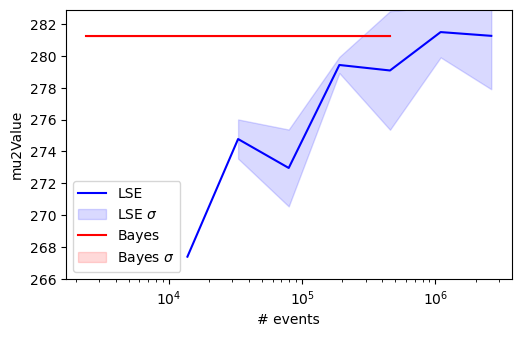

In [256]:
p_conv_plot(2)